# Read DWD CDC Time Series, Merge with Station Description and Append 

The main idea behind this activity is to reformat and merge time series (here we use hourly precipitation) from the DWD Climate Data Center in such a way that it can be used with the **QGIS time manager extension**. 

This extension allows to filter an attribute table of a vector layer (e.g. points representing precipitation stations plus precipitation data) with a time stamp column. The extension limits the attribute table to the records matching the particular time stamp provided by the time manager extension (e.g. by the user moving the time slider). This selected subset of the attribute table is then used to change the sympology of the vector layer according to the variable of interest (e.g. precipitation rate).

The QGIS time manager extension approach is a bit brute force, because each individual measurement at a station at a given time is one feature (row in the table), i.e. a time series at station X with hourly resolution for a day (24 values) entails 24 different features with the same station id and the corresponding coordinates but different times. As of now this 1:n relationship can only be realized by importing a CSV file with the according structure. 

(At least I was not able to generate the required view on a 1:n relationship by merging a point vector layer with precipitation station locations and an imported CSV time series table.)

The final data format is a concatenation of time series together with geographic location in 2D (e.g. lat, lon). The required data format looks principly like this:


| station_id |        name        |   lat   |   lon  |        meas_time       | prec_rate |
|:----------:|:------------------:|:-------:|:------:|:----------------------:|:---------:|
|        ... | ...                |     ... |    ... |                    ... |       ... |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T08:00:00UTC |       1.5 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T09:00:00UTC |       1.7 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T10:00:00UTC |       0.1 |
|        ... | ...                |     ... |    ... |                    ... |       ... |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T08:00:00UTC |       0.8 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T09:00:00UTC |       0.4 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T10:00:00UTC |       0.0 |
|        ... | ...                |     ... |    ... |                    ... |       ... |


(Table generated with https://www.tablesgenerator.com/markdown_tables)

To achieve this the precipitation time series (station_id, meas_time, prec_rate) have to be merged with the station metadata (station_id, lat, lon) coming from the a CSV file generated in an earlier activity. We use Pandas to read, join and append the data to generate the final CSV file to be imported as a point layer to QGIS. 

This final data format is far from being optimal because of large size and highly redundant information. This is a challenge for QGIS which loses responsiveness with large data. To jsut show the principle it is advisable to limit to size of the problem. 

The following filters (selection criteria) are applied:

  * Precipitation stations in NRW only (approx. 127 stations) 
  * Hourly precipitation data
  * Time interval from 2018-12-01 to last date in precipitation data set 
  
Still: 40 days * 24 hrs / day * 127 stations = 121920 records leading to 121920 features in a point layer in QGIS. 

In fact, the resulting number of records is arround 91000. The reason might be that not all stations in the station list have time series. This has to be checked carefully.

## FTP Connection

### Connection Parameters

In [20]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [21]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/hourly/precipitation/recent/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [22]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [23]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/
../data/original/DWD//hourly/precipitation/historical/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/


In [24]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [25]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [26]:
ret = ftp.cwd(".")

In [27]:
#ftp.quit()

### FTP Grab File Function

In [28]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [29]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [30]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [31]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,71445,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,69716,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,209079,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
4,20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
5,44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
6,53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
7,71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
8,73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
9,78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-


### Dataframe with TS Zip Files

In [32]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419265,-
20,stundenwerte_RR_00020_20040814_20191231_hist.zip,.zip,407378,-
44,stundenwerte_RR_00044_20070401_20191231_hist.zip,.zip,320516,-
53,stundenwerte_RR_00053_20051001_20191231_hist.zip,.zip,361931,-
71,stundenwerte_RR_00071_20041022_20191231_hist.zip,.zip,402880,-
73,stundenwerte_RR_00073_20070401_20191231_hist.zip,.zip,333070,-
78,stundenwerte_RR_00078_20041101_20191231_hist.zip,.zip,384729,-
87,stundenwerte_RR_00087_20050201_20191231_hist.zip,.zip,379869,-
91,stundenwerte_RR_00091_20040901_20191231_hist.zip,.zip,394972,-


### Download the Station Description File

In [33]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [34]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [35]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [36]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2021-01-25,432,48.9220,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
44,2007-04-01,2021-01-25,44,52.9336,8.2370,Großenkneten,Niedersachsen
53,2005-10-01,2021-01-25,60,52.5850,13.5634,Ahrensfelde,Brandenburg
71,2004-10-22,2020-01-01,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg


### Select Stations Located in NRW from Station Description Dataframe

In [37]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,   617,   644,   796,   871,   902,   934,   989,  1024,
             1046,  1078,  1241,  1246,  1300,  1303,  1327,  1590,  1595,
             1766,  2027,  2110,  2254,  2473,  2483,  2497,  2629,  2667,
             2703,  2810,  2947,  2968,  2999,  3028,  3031,  3081,  3098,
             3215,  3321,  3339,  3499,  3540,  3591,  3795,  3913,  4063,
             4127,  4150,  4154,  4313,  4368,  4371,  4400,  4488,  4692,
             4741,  4849,  5064,  5347,  5360,  5468,  5480,  5513,  5619,
             5699,  5717,  5719,  5733,  6197,  6264,  6276,  6313,  6337,
             7106,  7330,  7344,  7374,  7378, 13669, 13670, 13671, 13696,
            13700, 13713, 15000],
           dtype='int64', name='station_id')

In [38]:
# Create variable with TRUE if state is Nordrhein-Westfalen

# isNRW = df_stations['state'] == "Nordrhein-Westfalen"
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = (df_stations['date_to'] >= "2017-12-31") & (df_stations['date_from'] <= "2017-01-01")

#isBefore1950 = df_stations['date_from'] < '1950'
#dfNRW = df_stations[isNRW & isOperational & isBefore1950]

# select on both conditions

dfNRW = df_stations[isNRW & isOperational]

#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
216,2004-10-01,2021-01-25,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
389,2009-11-01,2021-01-25,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
390,2004-07-01,2021-01-25,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
554,1995-09-01,2021-01-25,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
555,2008-01-01,2018-11-01,101,51.4789,7.2697,Bochum,Nordrhein-Westfalen
...,...,...,...,...,...,...,...
13671,2007-12-01,2021-01-25,221,50.9655,7.2753,Overath-Böke,Nordrhein-Westfalen
13696,2007-12-01,2021-01-25,60,51.5966,7.4048,Waltrop-Abdinghof,Nordrhein-Westfalen
13700,2008-05-01,2021-01-25,205,51.3329,7.3411,Gevelsberg-Oberbröking,Nordrhein-Westfalen


In [39]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  419265   
20          stundenwerte_RR_00020_20040814_20191231_hist.zip  .zip  407378   
44          stundenwerte_RR_00044_20070401_20191231_hist.zip  .zip  320516   
53          stundenwerte_RR_00053_20051001_20191231_hist.zip  .zip  361931   
71          stundenwerte_RR_00071_20041022_20191231_hist.zip  .zip  402880   
...                                                      ...   ...     ...   
15478       stundenwerte_RR_15478_20150201_20191231_hist.zip  .zip  126658   
15490       stundenwerte_RR_15490_20161201_20191231_hist.zip  .zip   81166   
15512       stundenwerte_RR_15512_20160901_20191231_hist.zip  .zip   83934   
15514       stundenwerte_RR_15514_20171101_20191231_hist.zip  .zip   56846   
15555       stundenwerte_RR_15555_20160501_20191231_hist.zip  .z

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [27]:
list(dfNRW.index)

[216,
 390,
 554,
 603,
 613,
 617,
 644,
 796,
 871,
 902,
 934,
 989,
 1024,
 1046,
 1078,
 1241,
 1246,
 1300,
 1303,
 1327,
 1590,
 1595,
 1766,
 2027,
 2110,
 2254,
 2473,
 2483,
 2497,
 2629,
 2667,
 2810,
 2947,
 2968,
 2999,
 3028,
 3031,
 3081,
 3098,
 3321,
 3339,
 3499,
 3540,
 3591,
 3795,
 3913,
 4063,
 4127,
 4150,
 4313,
 4368,
 4371,
 4400,
 4488,
 4741,
 4849,
 5064,
 5347,
 5360,
 5480,
 5513,
 5619,
 5699,
 5717,
 5733,
 6197,
 6264,
 6313,
 6337,
 7106,
 7330,
 7344,
 7374,
 7378,
 13669,
 13670,
 13671,
 13696,
 13700,
 13713,
 15000]

In [30]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_akt.zip
stundenwerte_RR_00390_akt.zip
stundenwerte_RR_00554_akt.zip
stundenwerte_RR_00603_akt.zip
stundenwerte_RR_00613_akt.zip
stundenwerte_RR_00617_akt.zip
stundenwerte_RR_00644_akt.zip
stundenwerte_RR_00796_akt.zip
stundenwerte_RR_00871_akt.zip
stundenwerte_RR_00902_akt.zip
stundenwerte_RR_00934_akt.zip
stundenwerte_RR_00989_akt.zip
stundenwerte_RR_01024_akt.zip
stundenwerte_RR_01046_akt.zip
stundenwerte_RR_01078_akt.zip
stundenwerte_RR_01241_akt.zip
stundenwerte_RR_01246_akt.zip
stundenwerte_RR_01300_akt.zip
stundenwerte_RR_01303_akt.zip
stundenwerte_RR_01327_akt.zip
stundenwerte_RR_01590_akt.zip
stundenwerte_RR_01595_akt.zip
stundenwerte_RR_01766_akt.zip
stundenwerte_RR_02027_akt.zip
stundenwerte_RR_02110_akt.zip
stundenwerte_RR_02254_akt.zip
stundenwerte_RR_02473_akt.zip
stundenwerte_RR_02483_akt.zip
stundenwerte_RR_02497_akt.zip
stundenwerte_RR_02629_akt.zip
stundenwerte_RR_02667_akt.zip
stundenwerte_RR_02810_akt.zip
stundenwerte_RR_02947_akt.zip
stundenwer

### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [31]:
from datetime import datetime

def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [32]:
from datetime import datetime

def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [33]:
from zipfile import ZipFile

In [35]:
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [36]:
# TEMPERATURE
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [37]:
df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00216_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00390_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00554_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00603_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00603.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00613_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00613.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00617_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00617.txt

Zip archive: ../data/origina

In [38]:
df_merged_ts.shape

(13200, 81)

In [42]:
df_merged_ts.tail()

,216,390,554,603,613,617,644,796,871,902,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
2021-01-07 19:00:00,0.1,0.2,0.0,0.0,0.1,0.3,0.1,0.1,0.3,0.0,...,0.2,0.8,0.3,0.2,0.2,0.4,0.1,0.2,0.7,0.0
2021-01-07 20:00:00,0.3,0.0,0.3,0.0,0.0,0.8,0.1,0.3,0.8,0.1,...,0.1,0.1,0.6,0.2,0.5,1.1,0.4,0.4,0.8,0.1
2021-01-07 21:00:00,0.2,0.4,0.2,0.3,0.2,0.5,0.1,0.0,0.1,0.0,...,0.1,0.1,0.0,0.2,0.5,1.3,0.8,0.4,1.2,0.1
2021-01-07 22:00:00,0.3,0.3,0.3,0.2,0.2,0.3,0.0,0.2,0.4,0.0,...,0.0,0.0,0.0,0.1,0.3,0.5,0.8,0.3,0.7,0.0
2021-01-07 23:00:00,0.2,0.3,0.1,0.3,0.0,0.1,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.1,0.2,0.6,0.5,1.1,0.9,0.0


In [43]:
# prec or temp?
filepathname = local_ts_merged_dir + "prec_ts_merged.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")

df_merged_ts is saved to: ../data/generated/DWD//hourly/precipitation/recent/prec_ts_merged.csv


In [44]:
import matplotlib.pyplot as plt

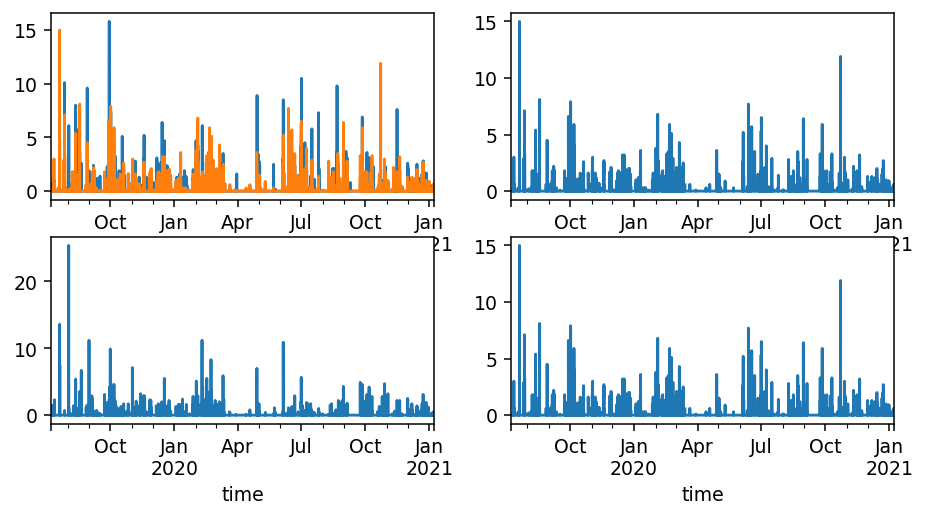

In [47]:
fig = plt.figure(dpi= 136, figsize=(8,4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
df_merged_ts[1303].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax1)
df_merged_ts[2110].plot(ax = ax2)
df_merged_ts[1590].plot(ax = ax3)
df_merged_ts[2110].plot(ax = ax4)
plt.show()

**Attention: The following code creates a heatmap. This makes only sense if the data density is low, e.g. annual temperatures. Do not use it for hourly precipitation over a long period.**

```
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 400, figsize = (12,24))

#sns.heatmap(df_merged_ts, cmap='RdYlGn_r', annot=False, ax = ax1)
sns.heatmap(df_merged_ts, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax1)

# _r reverses the normal order of the color map 'RdYlGn'

#sns.heatmap(df, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax)
ax1.set_yticklabels(df_merged_ts.index.strftime('%Y'))
plt.show()
fig1.savefig('example1.png')
```

In [48]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [49]:
df_merged_ts_transposed.index.names = ['station_id']

In [50]:
df_merged_ts_transposed.shape

(81, 13200)

In [53]:
df_merged_ts_transposed.head()

time,2019-07-08 00:00:00,2019-07-08 01:00:00,2019-07-08 02:00:00,2019-07-08 03:00:00,2019-07-08 04:00:00,2019-07-08 05:00:00,2019-07-08 06:00:00,2019-07-08 07:00:00,2019-07-08 08:00:00,2019-07-08 09:00:00,...,2021-01-07 14:00:00,2021-01-07 15:00:00,2021-01-07 16:00:00,2021-01-07 17:00:00,2021-01-07 18:00:00,2021-01-07 19:00:00,2021-01-07 20:00:00,2021-01-07 21:00:00,2021-01-07 22:00:00,2021-01-07 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.1,0.1,0.1,0.1,0.3,0.2,0.3,0.2
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.0,0.0,0.1,0.2,0.2,0.0,0.4,0.3,0.3
554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.3,0.2,0.0,0.0,0.3,0.2,0.3,0.1
603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.1,0.3,0.5,0.1,0.0,0.0,0.3,0.2,0.3
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.2,0.2,0.0


In [54]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed.csv"
print("df_merged_ts_transposed is saved to: %s" % (filepathname))
df_merged_ts_transposed.to_csv(filepathname,sep=";")

df_merged_ts_transposed is saved to: ../data/generated/DWD//hourly/precipitation/recent/prec_ts_merged_transposed.csv


In [56]:
df_merged_ts_transposed.iloc[2,:4]

time
2019-07-08 00:00:00    0.0
2019-07-08 01:00:00    0.0
2019-07-08 02:00:00    0.0
2019-07-08 03:00:00    0.0
Name: 554, dtype: float64

In [66]:
df_merged_ts_transposed_last_day = df_merged_ts_transposed.iloc[:,-24:]

In [67]:
df_merged_ts_transposed_last_day.shape

(81, 24)

In [68]:
df_merged_ts_transposed_last_day.head()

time,2021-01-07 00:00:00,2021-01-07 01:00:00,2021-01-07 02:00:00,2021-01-07 03:00:00,2021-01-07 04:00:00,2021-01-07 05:00:00,2021-01-07 06:00:00,2021-01-07 07:00:00,2021-01-07 08:00:00,2021-01-07 09:00:00,...,2021-01-07 14:00:00,2021-01-07 15:00:00,2021-01-07 16:00:00,2021-01-07 17:00:00,2021-01-07 18:00:00,2021-01-07 19:00:00,2021-01-07 20:00:00,2021-01-07 21:00:00,2021-01-07 22:00:00,2021-01-07 23:00:00
station_id,,,,,,,,,,,,,,,,,,,,,
216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,...,0.0,0.1,0.1,0.1,0.1,0.1,0.3,0.2,0.3,0.2
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.1,0.0,0.0,0.1,0.2,0.2,0.0,0.4,0.3,0.3
554,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.1,0.3,0.2,0.0,0.0,0.3,0.2,0.3,0.1
603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.3,0.1,0.3,0.5,0.1,0.0,0.0,0.3,0.2,0.3
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.2,0.2,0.0


In [69]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed_last_day.csv"
print("df_merged_ts_transposed_last_day saved to: %s" % (filepathname))
df_merged_ts_transposed_last_day.to_csv(filepathname,sep=";")

df_merged_ts_transposed_last_day saved to: ../data/generated/DWD//hourly/precipitation/recent/prec_ts_merged_transposed_last_day.csv


In [72]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
# TEMPERATURE                dftmp = temp_ts_to_df(myfile)
# PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [73]:
df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00216_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00390_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00554_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00554.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00603_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00603.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00613_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00613.txt

Zip archive: ../data/original/DWD//hourly/precipitation/recent/stundenwerte_RR_00617_akt.zip
Extract product file: produkt_rr_stunde_20190708_20210107_00617.txt

Zip archive: ../data/origina

In [74]:
df_appended_ts.shape

(1057173, 13)

In [75]:
df_appended_ts.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2019-07-08 00:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2019-07-08 01:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2019-07-08 02:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2019-07-08 03:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2019-07-08 04:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen


In [76]:
filepathname = local_ts_appended_dir + "prec_ts_appended.csv"
print("df_appended_ts saved to: %s" % (filepathname))
df_appended_ts.to_csv(filepathname,sep=";")

df_appended_ts saved to: ../data/generated/DWD//hourly/precipitation/recent/prec_ts_appended.csv


In [74]:
type(df_appended_ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [75]:
type(df_appended_ts.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [79]:
# datetime.fromisoformat(...)

In [80]:
df_appended_ts[["r1","longitude", "latitude"]]

,r1,longitude,latitude
mess_datum,,,
2019-07-08 00:00:00,0.0,7.8807,51.1143
2019-07-08 01:00:00,0.0,7.8807,51.1143
2019-07-08 02:00:00,0.0,7.8807,51.1143
2019-07-08 03:00:00,0.0,7.8807,51.1143
2019-07-08 04:00:00,0.0,7.8807,51.1143
...,...,...,...
2021-01-07 19:00:00,0.0,6.0244,50.7983
2021-01-07 20:00:00,0.1,6.0244,50.7983
2021-01-07 21:00:00,0.1,6.0244,50.7983


In [116]:
d3 = datetime.fromisoformat('2019-07-08 02:00:00')

In [117]:
type(d3)

datetime.datetime

In [123]:
idx = (df_appended_ts.index >= '2020-06-01 00:00:00') & (df_appended_ts.index < '2020-07-01 00:00:00') 

In [127]:
df_appended_ts_june = df_appended_ts[idx]

In [128]:
filepathname = local_ts_appended_dir + "prec_ts_appended_june.csv"
print("df_appended_ts_june saved to: %s" % (filepathname))
df_appended_ts_june.to_csv(filepathname,sep=";")

df_appended_ts_june saved to: ../data/generated/DWD//hourly/precipitation/recent/prec_ts_appended_june.csv


In [132]:
df_appended_ts_june[df_appended_ts_june["r1"] >= 0.5]

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2020-06-04 03:00:00,216,3,1.2,1.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2020-06-04 04:00:00,216,3,2.5,1.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2020-06-04 05:00:00,216,3,1.0,1.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2020-06-04 06:00:00,216,3,1.4,1.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2020-06-04 07:00:00,216,3,1.1,1.0,NaN,eor,2004-10-01,2021-01-08,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 18:00:00,15000,3,5.4,1.0,NaN,eor,2011-04-01,2021-01-08,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
2020-06-26 19:00:00,15000,3,3.8,1.0,6.0,eor,2011-04-01,2021-01-08,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
2020-06-28 23:00:00,15000,3,1.7,1.0,6.0,eor,2011-04-01,2021-01-08,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
